In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [89]:
# okt
!pip install konlpy
# !pip install git+https://github.com/ssut/py-hanspell.git

# 띄어쓰기
!pip install git+https://github.com/haven-jeon/PyKoSpacing.git

     |████████████████████████████████| 19.4 MB 1.4 MB/s 
     |████████████████████████████████| 448 kB 40.5 MB/s 
     |████████████████████████████████| 86 kB 4.6 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Cloning https://github.com/haven-jeon/PyKoSpacing.git to /tmp/pip-req-build-zodlqmc3
  Running command git clone -q https://github.com/haven-jeon/PyKoSpacing.git /tmp/pip-req-build-zodlqmc3
  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [90]:
from pykospacing import Spacing
spacing = Spacing()

from konlpy.tag import Okt
okt = Okt()

# 중복, 한글 외 제거
def duplicatesRemove(data) :
  #data.drop_duplicates(subset = ['comment'], inplace=True) # 중복 제거
  data['comment'] = data['comment'].str.replace("[^가-힣|ㄱ-ㅎ|ㅏ-ㅣ|0-9 ]","") # 한글+숫자 정규표현식
  data['comment'] = data['comment'].str.replace('^ +', "") # 공백은 empty 값으로 변경
  data['comment'].replace('', np.nan, inplace=True) #공백은 Null 값으로 변경
  data = data.dropna(how='any') # Null 값 제거
  data.reset_index(drop=True, inplace=True)
  return data

In [43]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
stopwords = ['이', '듯', '으로', '고', '인', '와', '하다', '의', '한', '다,', '은', '를', '가', '좀', 
             '자', '게', '도', '과', '네', '들', '는', '지', '잘', '에', '을', '걍', '임', '하']
import ast

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

# 전처리

In [21]:
route = '/content/drive/MyDrive/참빛설계[조랑말]'
data = pd.read_csv(route+'/csv/mbig_띄어쓰기_토큰.csv')
data.columns = ['index', 'comment', 'sentiment', 'token']
data = data[['index', 'token', 'sentiment', 'comment']]
data

,index,token,sentiment,comment
0,0,"['이', '거', '그거', '같다', '그', '분노', '의', '질주', '...",0.0,이 거 그거 같다 그 분노의 질주 더 익스트림에서 샤를리즈 테론 사이퍼 이 좀비 타...
1,1,"['아니', 'ㅋㅋ', '브레이크', '등', '왜', '안', '들어오냐고', '...",0.0,아니 ㅋㅋ 브레이크 등 왜 안 들어오냐고 아 ㅋㅋ
2,2,"['볼보', '운전자', '보다', '제', '가', '운전', '경력', '삼',...",0.0,볼보운전자보다 제가 운전 경력 삼십년 가까이 됩니다그동안 대우차 현대차 쉐보레 차 ...
3,3,"['주차', '부터', '멋지게', '하셨네요']",0.0,주차부터 멋지게 하셨네요
4,4,"['운전', '실력', '굳', '국기', '게양', '대', '파워', '클라스'...",0.0,운전 실력 굳 국기 게양대 파워 클라스 인정
...,...,...,...,...
5307,5307,"['자살', '할', '용기', '면', '죽', '이고', '죽지']",1.0,자살할 용기면 죽이고 죽지
5308,5308,"['대한민국', '진짜', '토', '나온', '다', '어떻게', '깨끗한', '...",1.0,대한민국 진짜 토 나온 다 어떻게 깨끗한 곳 하나 없냐
5309,5309,"['여자', '는', '군', '에서', '아예', '배재시', '킵시', '다',...",1.0,여자는 군에서 아예 배재시 킵시 다 이런 일 예방하려면 사병이 든 부사관이든 장교든...
5310,5310,"['군', '이나', '경이', '나', 'ㅈㄹ', '같다']",1.0,군이나 경이나 ㅈㄹ 같다


In [22]:
# str to list
for i in range(len(data)):
  if i % 1000 == 0:
    print(i)
  data['token'][i] = ast.literal_eval(data['token'][i])
print('done')

0
1000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


2000
3000
4000
5000
done


In [23]:
token = data.iloc[:, :3]
token

,index,token,sentiment
0,0,"[이, 거, 그거, 같다, 그, 분노, 의, 질주, 더, 익스트림, 에서, 샤를, ...",0.0
1,1,"[아니, ㅋㅋ, 브레이크, 등, 왜, 안, 들어오냐고, 아, ㅋㅋ]",0.0
2,2,"[볼보, 운전자, 보다, 제, 가, 운전, 경력, 삼, 십년, 가까이, 됩니다, 그...",0.0
3,3,"[주차, 부터, 멋지게, 하셨네요]",0.0
4,4,"[운전, 실력, 굳, 국기, 게양, 대, 파워, 클라스, 인정]",0.0
...,...,...,...
5307,5307,"[자살, 할, 용기, 면, 죽, 이고, 죽지]",1.0
5308,5308,"[대한민국, 진짜, 토, 나온, 다, 어떻게, 깨끗한, 곳, 하나, 없냐]",1.0
5309,5309,"[여자, 는, 군, 에서, 아예, 배재시, 킵시, 다, 이런, 일, 예방, 하려면,...",1.0
5310,5310,"[군, 이나, 경이, 나, ㅈㄹ, 같다]",1.0


In [24]:
train_data = token.sample(frac=0.8, random_state=2021)
temp = pd.concat([train_data, token])
test_data = temp.drop_duplicates(['index'], keep=False)
print(len(train_data), len(test_data))

4250 1062


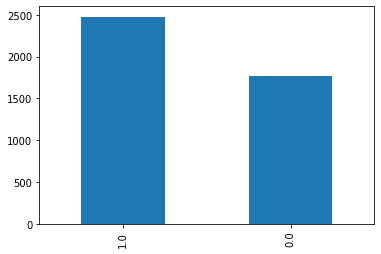

In [25]:
train_data['sentiment'].value_counts().plot(kind = 'bar')

In [26]:
X_train  = []
for token in train_data['token']:
    print(token)
    temp_X = [word for word in token if not word in stopwords] # 불용어 제거
    print('-> ', temp_X)
    X_train.append(temp_X)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
['나라꼬', '라지', '봐라', '이', '게', '나라', '냐', '보고', '있나', '문재인', '민주당', '새끼', '들', '아']
->  ['나라꼬', '라지', '봐라', '나라', '냐', '보고', '있나', '문재인', '민주당', '새끼', '아']
['아', '진짜', '패드', '립', '존', '나', '박고', '싶네']
->  ['아', '진짜', '패드', '립', '존', '나', '박고', '싶네']
['급발진', '주장', '영상', '특징', '1', '브레이크', '밟을', '타이밍', '에', '급발진', '이', '일어남', '2', '3040', '남자', '들', '은', '없음', '죄다', '여자', '또는', '늙은', '사람', '3', '브레이크', '등', '안', '들어옴']
->  ['급발진', '주장', '영상', '특징', '1', '브레이크', '밟을', '타이밍', '급발진', '일어남', '2', '3040', '남자', '없음', '죄다', '여자', '또는', '늙은', '사람', '3', '브레이크', '등', '안', '들어옴']
['고교', '야구', '부', '감독', '월급', '을', '학부모', '들', '이', '주는', '것', '도', '많이', '이', '상한', '데']
->  ['고교', '야구', '부', '감독', '월급', '학부모', '주는', '것', '많이', '상한', '데']
['대중교통', '영구', '이용', '못', '하게', '하고', '사회', '격리', '시켜야지', '저런', '놈', '들', '이', '싸이코패스', '로', '살인', '저지르고', '다님']
->  ['대중교통', '영구', '이용', '못', '하게', '하고', '사회', '격리', '시켜야지', '저런', '놈', '싸이코패스', '로', '살인', '저지르고', '다님']
['포르쉬', '에

In [27]:
X_test  = []
for token in test_data['token']:
    print(token)
    temp_X = [word for word in token if not word in stopwords] # 불용어 제거
    print('-> ', temp_X)
    X_test.append(temp_X)

['볼보', '운전자', '보다', '제', '가', '운전', '경력', '삼', '십년', '가까이', '됩니다', '그동안', '대우', '차', '현대차', '쉐보레', '차', '중형', '급', '신차', '만', '뽑아서', '운전', '해본', '결과', '외제차', '는', '무조건', '걸러', '야', '된다고', '봅니다', '사고', '시', '부품', '비', '인건비', '가', '타', '국산', '차', '에', '비해', '비쌉니다', '물론', '잘', '들', '아시겠지만', '국산', '차는', '해외', '수출', '용', '보다', '헉', '소리', '나오게', '국민', '들', '뒷북', '치', '게', '만드시는', '거', '알거에요', '그래도', '국내', '브랜드', '차량', '이', '써비스', '쎈', '타도', '많고', '부품', '준비', '돼', '있고', '외제차', '보다', '추천', '드립니', '다']
->  ['볼보', '운전자', '보다', '제', '운전', '경력', '삼', '십년', '가까이', '됩니다', '그동안', '대우', '차', '현대차', '쉐보레', '차', '중형', '급', '신차', '만', '뽑아서', '운전', '해본', '결과', '외제차', '무조건', '걸러', '야', '된다고', '봅니다', '사고', '시', '부품', '비', '인건비', '타', '국산', '차', '비해', '비쌉니다', '물론', '아시겠지만', '국산', '차는', '해외', '수출', '용', '보다', '헉', '소리', '나오게', '국민', '뒷북', '치', '만드시는', '거', '알거에요', '그래도', '국내', '브랜드', '차량', '써비스', '쎈', '타도', '많고', '부품', '준비', '돼', '있고', '외제차', '보다', '추천', '드립니', '다']
['키', '햐', '급발진', '나면', '고객', '탓', '국내', '나

In [28]:
print(X_train[:3])
print(X_test[:3])

[['얼마', '못', '살', '겄다', '너', '쯧쯧', '부디', '사고', '없길'], ['ㅋㅋㅋㅋ', '나라', '에도', 'ㅇ', 'ㅐ', 'ㅁ', 'ㅣ', 'ㄷ', 'ㅣ', '진', '사람', '많구나', '우리나라', '에만', '있을', '줄', '알았는데'], ['주차', '해', '놓은', '위치', '봐라', '김', '여사', 'ㅡㅡ']]
[['볼보', '운전자', '보다', '제', '운전', '경력', '삼', '십년', '가까이', '됩니다', '그동안', '대우', '차', '현대차', '쉐보레', '차', '중형', '급', '신차', '만', '뽑아서', '운전', '해본', '결과', '외제차', '무조건', '걸러', '야', '된다고', '봅니다', '사고', '시', '부품', '비', '인건비', '타', '국산', '차', '비해', '비쌉니다', '물론', '아시겠지만', '국산', '차는', '해외', '수출', '용', '보다', '헉', '소리', '나오게', '국민', '뒷북', '치', '만드시는', '거', '알거에요', '그래도', '국내', '브랜드', '차량', '써비스', '쎈', '타도', '많고', '부품', '준비', '돼', '있고', '외제차', '보다', '추천', '드립니', '다'], ['키', '햐', '급발진', '나면', '고객', '탓', '국내', '나', '국외', '나', 'ㅋㅋ'], ['ㅇㅋ', '볼보', '안타', '걸', '로']]


# 정수인코딩

In [30]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [31]:
print(tokenizer.word_index)
od=tokenizer.word_counts
lista = sorted(od.items())
print(lista)

{'거': 1, '다': 2, '안': 3, '하는': 4, '사람': 5, '저': 6, '나': 7, '진짜': 8, '에서': 9, '로': 10, '것': 11, '저런': 12, 'ㅋㅋ': 13, '만': 14, '하고': 15, '왜': 16, '아': 17, '개': 18, '못': 19, '그': 20, '말': 21, '놈': 22, '새끼': 23, 'ㅋㅋㅋ': 24, '할': 25, '때': 26, '더': 27, '요': 28, '이런': 29, '같은': 30, '뭐': 31, '일': 32, '수': 33, '내': 34, '야': 35, '적': 36, '생각': 37, '나라': 38, '그냥': 39, '너무': 40, '건': 41, '중국': 42, '있는': 43, '니': 44, 'ㅋㅋㅋㅋ': 45, '한국': 46, '차별': 47, '인간': 48, '해': 49, '소방관': 50, '대': 51, '하지': 52, '데': 53, '존': 54, '면': 55, '인데': 56, '냐': 57, '돈': 58, '감독': 59, '쓰레기': 60, '한테': 61, '라': 62, '법': 63, '미친': 64, '서': 65, '또': 66, '없는': 67, '여자': 68, '쳐': 69, '하면': 70, '뭔': 71, '여': 72, '걸': 73, 'ㅈ': 74, '함': 75, '분': 76, '발': 77, '시': 78, '세상': 79, 'ㅅㅂ': 80, 'ㅋ': 81, '줄': 82, '우리나라': 83, '어': 84, '인종': 85, '너': 86, '영상': 87, '하나': 88, '기': 89, '병신': 90, '무슨': 91, '우리': 92, '제': 93, '소리': 94, '애': 95, '흑인': 96, '욕': 97, '이나': 98, '까지': 99, '라고': 100, '참': 101, '되는': 102, '문제': 103, '저렇게': 104, '보고': 105, 

In [32]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합(vocabulary)의 크기 : 11562
등장 빈도가 1번 이하인 희귀 단어의 수: 6962
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 4600
단어 집합에서 희귀 단어의 비율: 60.214495761978895
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 13.728506073513172
단어 집합의 크기 : 4601


In [33]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [35]:
print(X_train[:3])
print(X_test[:3])

y_train = np.array(train_data['sentiment'])
y_test = np.array(test_data['sentiment'])

[[1273, 19, 125, 86, 2945, 579, 126, 899], [45, 38, 369, 735, 2164, 1463, 1741, 1463, 580, 5, 1274, 83, 1128, 326, 82, 678], [491, 49, 2165, 2166, 434, 347, 394, 195]]
[[204, 276, 139, 93, 342, 1371, 2055, 4369, 776, 1797, 1242, 143, 143, 739, 14, 342, 2634, 3430, 677, 3928, 35, 1038, 1173, 126, 78, 453, 1624, 143, 2822, 934, 2702, 1110, 1491, 139, 94, 4561, 148, 1105, 1, 267, 4559, 3301, 585, 1599, 604, 623, 510, 3430, 139, 2815, 2], [280, 116, 1601, 1137, 4559, 7, 7, 13], [204, 73, 10]]


# 빈 샘플 제거

In [38]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_train[:3]

[74, 189, 206]

In [39]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

4203
4203


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


# 패딩

댓글의 최대 길이 : 661
댓글의 평균 길이 : 10.40923150130859


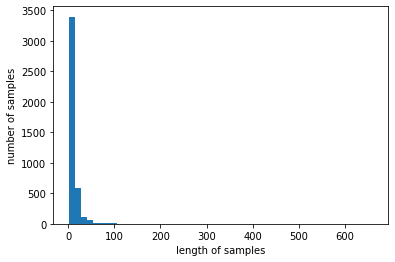

In [44]:
print('댓글의 최대 길이 :',max(len(l) for l in X_train))
print('댓글의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [45]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [47]:
max_len = 20
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 20 이하인 샘플의 비율: 89.74541993813942


In [46]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 95.47941946228885


In [48]:
max_len = 40
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 97.52557696883179


In [49]:
max_len = 50
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 98.76278848441589


In [51]:
max_len = 40

X_train = pad_sequences(X_train, maxlen = max_len, padding='pre')
X_test = pad_sequences(X_test, maxlen = max_len, padding= 'pre')

# LSTM

In [62]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [63]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [68]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('LSTM_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [69]:
#매우 오래 걸립니다 정상이에요..ㅜ

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# 데이터 손실이 4회 증가하면 조기 종료
# ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 저장
# validation_split : 훈련 데이터 중 몇%를 검증 데이터로 사용할 것인지

#파일을 불러오는 것이 아닌 위에 있는 X_train/y_train 변수에 선언된 것을 사용하는 것이므로,
# pre/post를 전환하려면 위에서 바꿔줘야함.
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
57/57 [==============================] - 8s 100ms/step - loss: 0.0773 - acc: 0.9738 - val_loss: 0.9513 - val_acc: 0.8002

Epoch 00001: val_acc improved from -inf to 0.80024, saving model to LSTM_model.h5
Epoch 2/15
57/57 [==============================] - 5s 92ms/step - loss: 0.0551 - acc: 0.9795 - val_loss: 0.9915 - val_acc: 0.7919

Epoch 00002: val_acc did not improve from 0.80024
Epoch 3/15
57/57 [==============================] - 5s 92ms/step - loss: 0.0434 - acc: 0.9854 - val_loss: 1.1303 - val_acc: 0.7955

Epoch 00003: val_acc did not improve from 0.80024
Epoch 4/15
57/57 [==============================] - 5s 92ms/step - loss: 0.0391 - acc: 0.9866 - val_loss: 1.1058 - val_acc: 0.8002

Epoch 00004: val_acc did not improve from 0.80024
Epoch 5/15
57/57 [==============================] - 5s 92ms/step - loss: 0.0282 - acc: 0.9896 - val_loss: 1.1262 - val_acc: 0.7848

Epoch 00005: val_acc did not improve from 0.80024
Epoch 6/15
57/57 [==============================] - 5s 92

In [70]:
# 로컬에 파일 다운로드

from google.colab import files
files.download('LSTM_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [71]:
# LSTM_model.h5 실행
# 위에 학습시킨 모델이면 불러오면 안됨
loaded_model = load_model(route+'/model/LSTM_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

loaded_model.summary()

34/34 [==============================] - 1s 17ms/step - loss: 0.8474 - acc: 0.8023

 테스트 정확도: 0.8023
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         460100    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 577,477
Trainable params: 577,477
Non-trainable params: 0
_________________________________________________________________


# BiLSTM

In [77]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [78]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation='sigmoid'))

In [79]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('BiLSTM_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [80]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=20, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/20
14/14 [==============================] - 10s 398ms/step - loss: 0.6684 - acc: 0.5797 - val_loss: 0.6386 - val_acc: 0.7444

Epoch 00001: val_acc improved from -inf to 0.74435, saving model to BiLSTM_model.h5
Epoch 2/20
14/14 [==============================] - 5s 335ms/step - loss: 0.6275 - acc: 0.7576 - val_loss: 0.5988 - val_acc: 0.7408

Epoch 00002: val_acc did not improve from 0.74435
Epoch 3/20
14/14 [==============================] - 5s 340ms/step - loss: 0.5285 - acc: 0.8141 - val_loss: 0.5459 - val_acc: 0.7491

Epoch 00003: val_acc improved from 0.74435 to 0.74911, saving model to BiLSTM_model.h5
Epoch 4/20
14/14 [==============================] - 5s 342ms/step - loss: 0.4223 - acc: 0.8670 - val_loss: 1.2521 - val_acc: 0.4685

Epoch 00004: val_acc did not improve from 0.74911
Epoch 5/20
14/14 [==============================] - 5s 348ms/step - loss: 0.4519 - acc: 0.8355 - val_loss: 0.4849 - val_acc: 0.7860

Epoch 00005: val_acc improved from 0.74911 to 0.78597, saving m

In [81]:
# 로컬에 파일 다운로드

from google.colab import files
files.download('BiLSTM_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [82]:
loaded_model = load_model(route+'/model/BiLSTM_model.h5')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

34/34 [==============================] - 1s 15ms/step - loss: 0.6497 - acc: 0.8023
테스트 정확도: 0.8023


In [97]:
# loaded_model = load_model(route+'/model/LSTM_model.h5')
loaded_model = load_model(route+'/model/BiLSTM_model.h5')

def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  print(score)
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 댓글입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 댓글입니다.\n".format((1 - score) * 100))

In [104]:
sentiment_predict('멍청한 lstm')

0.043207138776779175
95.68% 확률로 부정 댓글입니다.

